In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage, rdMolDraw2D  # For generating images
import base64  # For encoding images for Plotly hover
from io import BytesIO  # For handling image data in memory
from PIL import Image, ImageDraw
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap.umap_ as umap
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objects as go

try:
    from mordred import Calculator, descriptors as mordred_descriptors

    MORDRED_AVAILABLE = True
except ImportError:
    MORDRED_AVAILABLE = False
    Calculator = None  # mordred.Calculator
    mordred_descriptors = None  # mordred.descriptors

try:
    from openTSNE import (
        TSNE as OpenTSNE,
    )  # Use an alias to avoid conflict with sklearn.manifold.TSNE

    OPENTSNE_AVAILABLE = True
except ImportError:
    OPENTSNE_AVAILABLE = False
    OpenTSNE = None

In [2]:

from helpers import plot_scatter_plotly_2d, plot_scatter_plotly_3d


In [3]:
# 1. Load or Define Your Dataset
# For demonstration, we'll use a small list of 100 SMILES strings from ZINC.
# In a real scenario, you might load this from a CSV or SDF file.

with open("SMILES_ZINC_5000.csv", "r") as f:
    smiles_list = [line.strip() for line in f.readlines()][:5000]

molecule_names = smiles_list # [f"Mol_{i+1}" for i in range(len(smiles_list))]

# For later, lets create another small list of recognizable molecules
smiles_list_extra = [
    "CCO",  # Ethanol
    "CCC",  # Propane
    "c1ccccc1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "CNC(=O)C1=C(C=C(C=C1)N)N=NC2=CC=C(C=C2)S(=O)(=O)N", # Prontosil
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", # Ibuprofen
    "COC1=CC=C(C=C1)C(C2=CC=C(C=C2)OC)O", # Anisoin
    "CC1=C(C(=O)N(C1=O)C2=CC=CC=C2)C3=CC=CC=C3", # Phenazone
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", # Caffeine
    "C1=CC=C(C=C1)C(C2=CC=CC=C2)O", # Benzhydrol
    "CC(=O)OC1=CC=CC=C1C(=O)O" # Aspirin
]

molecule_names_extra = smiles_list_extra #[f"Mol_{i+1+len(smiles_list)}" for i in range(len(smiles_list_extra))]

In [4]:
# 2. Generate Fingerprints
# Convert SMILES to RDKit molecule objects
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
mols_extra = [Chem.MolFromSmiles(s) for s in smiles_list_extra]

# Filter out any molecules that couldn't be parsed
valid_mols_indices = [i for i, mol in enumerate(mols) if mol is not None]
mols = [mols[i] for i in valid_mols_indices]
molecule_names = [molecule_names[i] for i in valid_mols_indices]

if not mols:
    raise ValueError("No valid molecules could be parsed from the SMILES list.")

# Using Morgan fingerprints (similar to ECFP)
def generate_morgan_fingerprints(mol, radius=2, nBits=1024):
    """Generates Morgan fingerprints for a molecule."""
    if mol is None:
        return np.zeros((nBits,), dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(list(fp.ToBitString()), dtype=int)

fingerprints = np.array([generate_morgan_fingerprints(mol) for mol in mols])
fp_df = pd.DataFrame(fingerprints, columns=[f"FP_{i}" for i in range(fingerprints.shape[1])])
fp_df.index = molecule_names

In [5]:
# 3. Generate Descriptors
# Select a few 2D descriptors
descriptor_names = [
    "MolWt", "HeavyAtomCount", "NumHAcceptors", "NumHDonors",
    "MolLogP", "TPSA", "NumRotatableBonds", "RingCount"
]

def calculate_descriptors(mol, descriptor_list):
    """Calculates a list of RDKit descriptors for a molecule."""
    if mol is None:
        return [np.nan] * len(descriptor_list)
    vals = []
    for desc_name in descriptor_list:
        try:
            # Descriptor functions are attributes of the Descriptors module
            desc_func = getattr(Descriptors, desc_name)
            vals.append(desc_func(mol))
        except AttributeError:
            print(f"Warning: Descriptor {desc_name} not found.")
            vals.append(np.nan)
        except Exception as e:
            print(f"Warning: Could not calculate {desc_name} for a molecule: {e}")
            vals.append(np.nan)
    return vals

descriptors_data = np.array([calculate_descriptors(mol, descriptor_names) for mol in mols])
desc_df = pd.DataFrame(descriptors_data, columns=descriptor_names)
desc_df.index = molecule_names

descriptors_data_extra = np.array([calculate_descriptors(mol, descriptor_names) for mol in mols_extra])
desc_df_extra = pd.DataFrame(descriptors_data_extra, columns=descriptor_names)
desc_df_extra.index = molecule_names_extra

# Handle potential NaN values from descriptor calculation (e.g., if a descriptor can't be computed)
# A simple strategy is to fill with the mean, or you could drop rows/columns or use more sophisticated imputation.
desc_df = desc_df.fillna(desc_df.mean())

In [6]:
# 3b. Generate MORDRED Descriptors - alternative to RDKit 2D descriptors
if MORDRED_AVAILABLE:
    print("\nCalculating MORDRED descriptors...")
    # Initialize Mordred calculator. We'll ignore 3D descriptors for simplicity as we only have SMILES.
    mordred_calc = Calculator(mordred_descriptors, ignore_3D=True)

    # Calculate Mordred descriptors for all valid molecules
    # mordred_calc.pandas() returns a DataFrame
    mordred_desc_df_raw = mordred_calc.pandas(mols)

    # Mordred might return special 'Missing' objects or exceptions as strings.
    # Convert all columns to numeric, coercing errors to NaN.
    mordred_desc_df = mordred_desc_df_raw.apply(pd.to_numeric, errors='coerce')

    # Handle NaN values (e.g., fill with mean).
    # First, drop columns that are all NaN (if any descriptor failed for all molecules)
    mordred_desc_df = mordred_desc_df.dropna(axis=1, how='all')
    # Then fill remaining NaNs with the mean of their respective column
    mordred_desc_df = mordred_desc_df.fillna(mordred_desc_df.mean())
    mordred_desc_df.index = molecule_names # Align index with other dataframes
    print(f"Calculated {mordred_desc_df.shape[1]} MORDRED descriptors.")
else:
    print("\nMORDRED library not found. Skipping MORDRED descriptor calculation.")
    # Initialize mordred_desc_df as None or an empty DataFrame if you plan to use it later
    # For this notebook, if features_df_mordred is used, it would require mordred_desc_df to be defined.
    # If you uncomment that line, you might want to initialize mordred_desc_df to an empty DataFrame here:
    # mordred_desc_df = pd.DataFrame(index=molecule_names)
    mordred_desc_df = None # Or pd.DataFrame() if you uncomment the line below


MORDRED library not found. Skipping MORDRED descriptor calculation.


In [7]:
# 4. Combine Features if we want to
# Feature set 1: RDKit Fingerprints + RDKit 2D Descriptors
features_df_rdkit = pd.concat([fp_df, desc_df], axis=1)

# Feature set 2: RDKit Fingerprints + MORDRED Descriptors
if MORDRED_AVAILABLE and mordred_desc_df is not None:
    features_df_mordred = pd.concat([fp_df, mordred_desc_df], axis=1)
    print("\nCreated features_df_mordred by combining fingerprints and MORDRED descriptors.")
    


In [8]:
# 5. Preprocessing
scaler_rdkit = StandardScaler()

# We choose one set of features to work with
scaled_features = scaler_rdkit.fit_transform(desc_df)

# We can apply the scaler to unseen molecules without changing the scaler!
scaled_features_extra = scaler_rdkit.transform(desc_df_extra)

In [9]:
# 6. Visualize with PCA
n_components = 2
pca_rdkit = PCA(n_components=n_components, random_state=42) # Added random_state for reproducibility
principal_components_rdkit = pca_rdkit.fit_transform(scaled_features)

pca_df_rdkit = pd.DataFrame(data=principal_components_rdkit,
                      columns=[f'Principal Component {i+1}' for i in range(n_components)])
pca_df_rdkit.index = molecule_names

# Explained variance
explained_variance_ratio_rdkit = pca_rdkit.explained_variance_ratio_
print(f"Explained variance by PCA components (RDKit Descriptors): {explained_variance_ratio_rdkit}")
print(f"Total explained variance (RDKit Descriptors): {sum(explained_variance_ratio_rdkit):.2f}")

# Visualize the Chemical Space using Plotly
fig_pca_2d = plot_scatter_plotly_2d(
    df=pca_df_rdkit,
    x_col='Principal Component 1',
    y_col='Principal Component 2',
    text_col_data=pca_df_rdkit.index, # Use index for text annotations
    title='Chemical Space Visualization using PCA',
    labels_dict={
        'Principal Component 1': f'Principal Component 1 ({explained_variance_ratio_rdkit[0]:.2f} variance)',
        'Principal Component 2': f'Principal Component 2 ({explained_variance_ratio_rdkit[1]:.2f} variance)'
    },
    marker_size=8,
    text_position='top right',
)
fig_pca_2d.show()

# Original Matplotlib/Seaborn code:
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='Principal Component 1', y='Principal Component 2', data=pca_df_rdkit, s=100, legend=False)
# for i, name in enumerate(pca_df_rdkit.index):
#     plt.annotate(name, (pca_df_rdkit.iloc[i, 0], pca_df_rdkit.iloc[i, 1]), textcoords=\"offset points\", xytext=(5,5), ha='left')
# plt.title('Chemical Space Visualization using PCA')
# plt.xlabel(f'Principal Component 1 ({explained_variance_ratio_rdkit[0]:.2f} variance)')
# plt.ylabel(f'Principal Component 2 ({explained_variance_ratio_rdkit[1]:.2f} variance)')
# plt.grid(True)
# plt.axhline(0, color='grey', lw=0.5)
# plt.axvline(0, color='grey', lw=0.5)
# plt.show()


Explained variance by PCA components (RDKit Descriptors): [0.43022843 0.2095878 ]
Total explained variance (RDKit Descriptors): 0.64


In [10]:
# 6c. Visualize with PCA (3D)
n_components_3d = 3
pca_3d = PCA(n_components=n_components_3d, random_state=42)
principal_components_3d = pca_3d.fit_transform(scaled_features)

pca_df_3d = pd.DataFrame(data=principal_components_3d,
                         columns=[f'Principal Component {i+1}' for i in range(n_components_3d)])
pca_df_3d.index = molecule_names

# Explained variance
explained_variance_ratio_3d = pca_3d.explained_variance_ratio_
print(f"Explained variance by 3D PCA components: {explained_variance_ratio_3d}")
print(f"Total explained variance by 3D PCA: {sum(explained_variance_ratio_3d):.2f}")

# Visualize the Chemical Space in 3D using Plotly
fig_pca_3d = plot_scatter_plotly_3d(
    df=pca_df_3d,
    x_col='Principal Component 1',
    y_col='Principal Component 2',
    z_col='Principal Component 3',
    text_col_data=pca_df_3d.index, # Use index for text annotations
    title='Chemical Space Visualization using 3D PCA',
    scene_labels={ # Use scene_labels for 3D axis titles
        'Principal Component 1': f'PC 1 ({explained_variance_ratio_3d[0]:.2f} var)',
        'Principal Component 2': f'PC 2 ({explained_variance_ratio_3d[1]:.2f} var)',
        'Principal Component 3': f'PC 3 ({explained_variance_ratio_3d[2]:.2f} var)'
    },
    marker_size=8,
)
fig_pca_3d.show()

# Original Matplotlib code:
# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(pca_df_3d['Principal Component 1'],
#                 pca_df_3d['Principal Component 2'],
#                 pca_df_3d['Principal Component 3'],
#                 s=100)
# for i, name in enumerate(pca_df_3d.index):
#     ax.text(pca_df_3d.iloc[i, 0],
#             pca_df_3d.iloc[i, 1],
#             pca_df_3d.iloc[i, 2],
#             name,
#             size=8, zorder=1, color='k')
# ax.set_title('Chemical Space Visualization using 3D PCA')
# ax.set_xlabel(f'PC 1 ({explained_variance_ratio_3d[0]:.2f} var)')
# ax.set_ylabel(f'PC 2 ({explained_variance_ratio_3d[1]:.2f} var)')
# ax.set_zlabel(f'PC 3 ({explained_variance_ratio_3d[2]:.2f} var)')
# plt.show()

Explained variance by 3D PCA components: [0.43022843 0.2095878  0.13937939]
Total explained variance by 3D PCA: 0.78


In [11]:
# 6c. Analyze PCA Component Loadings (Feature Contributions)

# For the 2D PCA (pca_rdkit, based on desc_df)
if 'pca_rdkit' in locals() and 'desc_df' in locals():
    print("Feature contributions to 2D Principal Components (Loadings):\n")
    loadings_2d_df = pd.DataFrame(
        pca_rdkit.components_,
        columns=desc_df.columns, # Original feature names
        index=[f'Principal Component {i+1}' for i in range(pca_rdkit.n_components_)]
    )
    # Display the full loadings matrix (can be large if many features)
    # print(loadings_2d_df.T)

    # Display top N features for each component by absolute loading value
    n_top_features = 5 
    for pc_name in loadings_2d_df.index:
        print(f"\nTop {n_top_features} features for {pc_name}:")
        pc_loadings = loadings_2d_df.loc[pc_name]
        sorted_loadings = pc_loadings.abs().sort_values(ascending=False)
        print(loadings_2d_df.loc[pc_name, sorted_loadings.index[:n_top_features]])
else:
    print("Skipping 2D PCA component analysis: pca_rdkit or desc_df not found.")

# For the 3D PCA (pca_3d, also based on desc_df via scaled_features)
if 'pca_3d' in locals() and 'desc_df' in locals():
    print("\n\nFeature contributions to 3D Principal Components (Loadings):\n")
    loadings_3d_df = pd.DataFrame(
        pca_3d.components_,
        columns=desc_df.columns, # Original feature names
        index=[f'Principal Component {i+1}' for i in range(pca_3d.n_components_)]
    )
    n_top_features = 5
    for pc_name in loadings_3d_df.index:
        print(f"\nTop {n_top_features} features for {pc_name}:")
        pc_loadings = loadings_3d_df.loc[pc_name]
        sorted_loadings = pc_loadings.abs().sort_values(ascending=False)
        print(loadings_3d_df.loc[pc_name, sorted_loadings.index[:n_top_features]])
else:
    print("\nSkipping 3D PCA component analysis: pca_3d or desc_df not found.")


Feature contributions to 2D Principal Components (Loadings):


Top 5 features for Principal Component 1:
HeavyAtomCount    0.509780
MolWt             0.500627
RingCount         0.400618
NumHAcceptors     0.379788
TPSA              0.320061
Name: Principal Component 1, dtype: float64

Top 5 features for Principal Component 2:
NumHDonors           0.542650
MolLogP             -0.524717
TPSA                 0.491310
NumRotatableBonds    0.300296
RingCount           -0.255662
Name: Principal Component 2, dtype: float64


Feature contributions to 3D Principal Components (Loadings):


Top 5 features for Principal Component 1:
HeavyAtomCount    0.509780
MolWt             0.500627
RingCount         0.400618
NumHAcceptors     0.379788
TPSA              0.320061
Name: Principal Component 1, dtype: float64

Top 5 features for Principal Component 2:
NumHDonors           0.542650
MolLogP             -0.524717
TPSA                 0.491310
NumRotatableBonds    0.300296
RingCount           -0.255662



Determining optimal number of clusters using Elbow Method for KMeans...


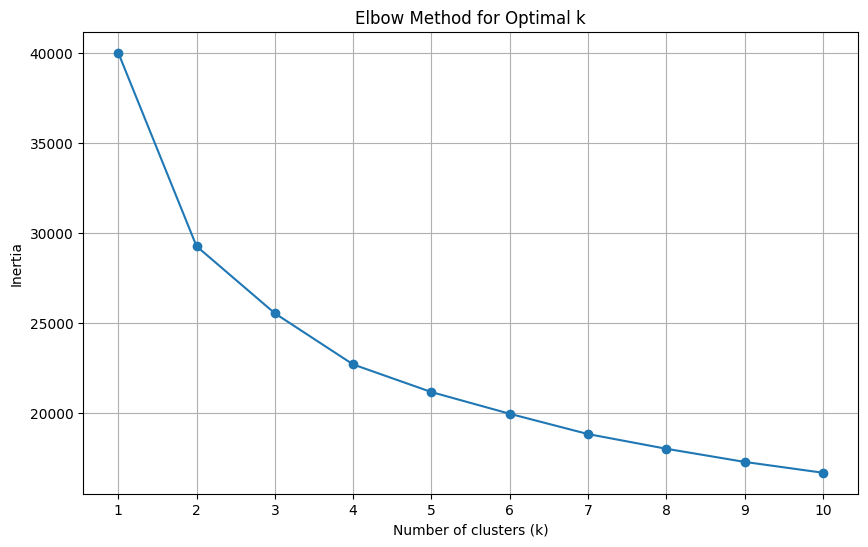


Performing KMeans clustering with k=5...
Cluster labels: [0 4 3 ... 0 1 4]


In [12]:
# 7. Clustering with KMeans and Elbow Plot
if scaled_features.shape[0] > 1:
    print("\nDetermining optimal number of clusters using Elbow Method for KMeans...")
    inertia = []
    # Consider a range of k values. Max k should be less than number of samples.
    max_k = min(10, scaled_features.shape[0] -1) # Max 10 clusters or n_samples-1
    k_range = range(1, max_k + 1)

    if max_k > 0:
        for k_val in k_range:
            kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
            kmeans.fit(scaled_features)
            inertia.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, marker='o')
        plt.title('Elbow Method for Optimal k')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()

        # Based on the elbow plot, choose an optimal k.
        # For this small dataset, let's assume k=3 or k=4 might be reasonable.
        # You would typically inspect the plot to find the "elbow".
        optimal_k = 5 # Example: Choose 3 clusters. Adjust based on your elbow plot.
        if optimal_k > max_k:
            optimal_k = max_k # Ensure optimal_k is not too large
        
        if optimal_k > 0:
            print(f"\nPerforming KMeans clustering with k={optimal_k}...")
            kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
            cluster_labels_kmeans = kmeans_final.fit_predict(scaled_features)
            print(f"Cluster labels: {cluster_labels_kmeans}")
        else:
            print("Skipping KMeans clustering as optimal_k is 0.")
            cluster_labels_kmeans = None
    else:
        print("Skipping Elbow Method: Not enough samples to form multiple clusters.")
        cluster_labels_kmeans = None
else:
    print("Skipping Clustering: Not enough samples.")
    cluster_labels_kmeans = None

In [13]:
# 7b. Clustering with Agglomerative Clustering
if 'scaled_features' in locals() and scaled_features.shape[0] > 1:
    # Define the number of clusters. This can be based on domain knowledge, elbow method for other algorithms, or a fixed value.
    # Here, we try to use optimal_k from KMeans if available and valid, otherwise a default.
    n_clusters_agg = 0
    if 'optimal_k' in locals() and isinstance(optimal_k, int) and optimal_k > 0 and optimal_k <= scaled_features.shape[0]:
        n_clusters_agg = optimal_k
        print(f"Using optimal_k = {optimal_k} from KMeans for Agglomerative Clustering.")
    else:
        # Fallback: choose a number of clusters, e.g., 3 or 5, or make it dynamic based on sample size
        n_clusters_agg = min(5, scaled_features.shape[0]) # Default to 5 or max possible if less than 5 samples
        if scaled_features.shape[0] < 2: n_clusters_agg = 0 # Cannot cluster if < 2 samples
        print(f"optimal_k from KMeans not available or invalid. Using n_clusters = {n_clusters_agg} for Agglomerative Clustering.")

    if n_clusters_agg >= 2: # AgglomerativeClustering needs n_clusters >= 2
        print(f"\nPerforming Agglomerative Clustering with n_clusters={n_clusters_agg}...")
        agg_clustering_model = AgglomerativeClustering(n_clusters=n_clusters_agg)
        cluster_labels_agg = agg_clustering_model.fit_predict(scaled_features)
        print(f"Agglomerative cluster labels (first 50): {cluster_labels_agg[:50]}")
    else:
        print("Skipping Agglomerative Clustering: Not enough samples or n_clusters < 2.")
        cluster_labels_agg = None
else:
    print("\nSkipping Agglomerative Clustering: scaled_features not available or not enough samples.")
    cluster_labels_agg = None

Using optimal_k = 5 from KMeans for Agglomerative Clustering.

Performing Agglomerative Clustering with n_clusters=5...
Agglomerative cluster labels (first 50): [4 3 2 1 3 1 2 0 0 2 1 2 3 1 1 2 4 2 1 1 0 3 3 0 0 4 1 3 0 0 1 1 2 0 0 0 3
 1 1 3 0 1 0 3 2 3 0 1 2 0]


In [14]:
# 7c. Clustering with DBSCAN
if 'scaled_features' in locals() and scaled_features.shape[0] > 1:
    # DBSCAN parameters: 
    # eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    # min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    # These parameters are sensitive and often require tuning based on the dataset.

    # Example parameters (these will likely need adjustment for your specific dataset)
    dbscan_eps = 0.5 # This is a critical parameter to tune.
    if scaled_features.shape[1] > 0:
        dbscan_min_samples = max(3, 2 * scaled_features.shape[1]) # e.g., 2 * number_of_features
    else: 
        dbscan_min_samples = 5 

    # Ensure min_samples is not greater than the number of samples and at least 1
    if scaled_features.shape[0] < dbscan_min_samples:
        print(f"Warning: min_samples ({dbscan_min_samples}) is too large for the number of samples ({scaled_features.shape[0]}).")
        dbscan_min_samples = max(1, scaled_features.shape[0] // 10) # Adjust to a fraction or a small number
        if scaled_features.shape[0] == 1 : dbscan_min_samples = 1
        print(f"Adjusted min_samples to {dbscan_min_samples}.")

    if dbscan_min_samples > 0 and scaled_features.shape[0] >= dbscan_min_samples:
        try:
            dbscan_model = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
            cluster_labels_dbscan = dbscan_model.fit_predict(scaled_features)
            
            n_clusters_dbscan_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
            n_noise_dbscan_ = list(cluster_labels_dbscan).count(-1)
            
            print(f"DBSCAN estimated number of clusters: {n_clusters_dbscan_}")
            print(f"DBSCAN estimated number of noise points: {n_noise_dbscan_}")
            # print(f"DBSCAN cluster labels (first 50): {cluster_labels_dbscan[:50]}") # Can be very long
        except ValueError as e:
            print(f"Error during DBSCAN: {e}. Skipping DBSCAN.")
            cluster_labels_dbscan = None
    else:
        print(f"Skipping DBSCAN: Not enough samples ({scaled_features.shape[0]}) for min_samples ({dbscan_min_samples}), or min_samples is 0.")
        cluster_labels_dbscan = None
else:
    print("\nSkipping DBSCAN clustering: scaled_features not available or not enough samples.")
    cluster_labels_dbscan = None

DBSCAN estimated number of clusters: 0
DBSCAN estimated number of noise points: 5000


In [15]:
# 7d. Visualize 2D PCA with cluster Labels
if 'cluster_labels_kmeans' in locals() and cluster_labels_kmeans is not None and 'pca_df_rdkit' in locals() and 'explained_variance_ratio_rdkit' in locals():
    pca_df_rdkit_clustered = pca_df_rdkit.copy()
    pca_df_rdkit_clustered['Cluster'] = cluster_labels_kmeans
    # Plotly handles categorical coloring automatically, ensure 'Cluster' column is suitable (e.g., string or category)
    pca_df_rdkit_clustered['Cluster'] = pca_df_rdkit_clustered['Cluster'].astype(str)


    fig_pca_2d_clustered = plot_scatter_plotly_2d(
        df=pca_df_rdkit_clustered,
        x_col='Principal Component 1',
        y_col='Principal Component 2',
        color_col='Cluster',
        text_col_data=pca_df_rdkit_clustered.index,
        title='2D PCA with KMeans Cluster Labels',
        labels_dict={
            'Principal Component 1': f'Principal Component 1 ({explained_variance_ratio_rdkit[0]:.2f} variance)',
            'Principal Component 2': f'Principal Component 2 ({explained_variance_ratio_rdkit[1]:.2f} variance)',
            'Cluster': 'Cluster'
        },
        marker_size=8,
        text_position='top right',
        # color_discrete_map can be used here if specific colors are desired for clusters
    )
    fig_pca_2d_clustered.show()
else:
    print("Skipping 2D PCA with KMeans cluster colors: Prerequisite data not available.")



In [16]:
# 7e. Visualize 3D PCA with cluster Labels
if 'cluster_labels_kmeans' in locals() and cluster_labels_kmeans is not None and 'pca_df_3d' in locals() and 'explained_variance_ratio_3d' in locals():
    pca_df_3d_clustered = pca_df_3d.copy()
    pca_df_3d_clustered['Cluster'] = cluster_labels_kmeans
    # Plotly handles categorical coloring automatically, ensure 'Cluster' column is suitable
    pca_df_3d_clustered['Cluster'] = pca_df_3d_clustered['Cluster'].astype(str)

    fig_pca_3d_clustered = plot_scatter_plotly_3d(
        df=pca_df_3d_clustered,
        x_col='Principal Component 1',
        y_col='Principal Component 2',
        z_col='Principal Component 3',
        color_col='Cluster',
        text_col_data=pca_df_3d_clustered.index,
        title='3D PCA with KMeans Cluster Labels',
        scene_labels={
            'Principal Component 1': f'PC 1 ({explained_variance_ratio_3d[0]:.2f} var)',
            'Principal Component 2': f'PC 2 ({explained_variance_ratio_3d[1]:.2f} var)',
            'Principal Component 3': f'PC 3 ({explained_variance_ratio_3d[2]:.2f} var)',
            'Cluster': 'Cluster'
        },
        marker_size=8,
        text_position='top right',
        # color_discrete_map can be used here
    )
    fig_pca_3d_clustered.show()
else:
    print("Skipping 3D PCA with KMeans cluster colors: Prerequisite data not available.")


In [17]:
# 8. Visualize with t-SNE (can sometimes give better cluster separation)
if 'scaled_features' in locals() and scaled_features.shape[0] > 1: # t-SNE needs more than 1 sample
    # Adjust perplexity based on your dataset size, typically 5-50
    perplexity_value = min(30, scaled_features.shape[0] - 1)
    if perplexity_value > 0:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, max_iter=300, init='pca') # Added init='pca' for stability
        tsne_results = tsne.fit_transform(scaled_features) # or scaled_features_mordred

        tsne_df = pd.DataFrame(data=tsne_results,
                               columns=['t-SNE Component 1', 't-SNE Component 2'])
        tsne_df.index = molecule_names

        fig_tsne = plot_scatter_plotly_2d(
            df=tsne_df,
            x_col='t-SNE Component 1',
            y_col='t-SNE Component 2',
            text_col_data=tsne_df.index,
            title='Chemical Space Visualization using t-SNE',
            labels_dict={
                't-SNE Component 1': 't-SNE Component 1',
                't-SNE Component 2': 't-SNE Component 2'
            },
            marker_size=8,
            text_position='top right',
            add_zerolines=False # t-SNE axes don't typically have meaning at zero
        )
        fig_tsne.show()
    else:
        print("Skipping t-SNE: Not enough samples for the chosen perplexity.")
        tsne_df = None # Ensure tsne_df is defined if t-SNE is skipped
else:
    print("Skipping t-SNE: Not enough samples or scaled_features not available.")
    tsne_df = None # Ensure tsne_df is defined if t-SNE is skipped




In [18]:
# 8b. Cluster with Agglomerative Clustering and Color t-SNE Plot
if 'scaled_features' in locals() and scaled_features.shape[0] > 1:
    # Check if tsne_df was created (i.e., t-SNE ran successfully)
    if 'tsne_df' in locals() and tsne_df is not None and not tsne_df.empty:
        n_clusters = 0
        if scaled_features.shape[0] > 0:
            n_clusters = min(4, scaled_features.shape[0]) 

        if n_clusters >= 2: 
            agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
            cluster_labels = agg_clustering.fit_predict(scaled_features)

            tsne_df_clustered = tsne_df.copy()
            tsne_df_clustered['Cluster'] = cluster_labels
            tsne_df_clustered['Cluster'] = tsne_df_clustered['Cluster'].astype(str) 

            fig_tsne_clustered = plot_scatter_plotly_2d(
                df=tsne_df_clustered,
                x_col='t-SNE Component 1',
                y_col='t-SNE Component 2',
                color_col='Cluster',
                text_col_data=tsne_df_clustered.index,
                title=f't-SNE Visualization with {n_clusters} Agglomerative Clusters',
                labels_dict={
                    't-SNE Component 1': 't-SNE Component 1',
                    't-SNE Component 2': 't-SNE Component 2',
                    'Cluster': 'Cluster'
                },
                marker_size=8,
                text_position='top right',
                add_zerolines=False
            )
            fig_tsne_clustered.show()
        else:
            print("Skipping Agglomerative Clustering: Not enough samples or clusters to form meaningful groups (need at least 2 clusters and enough samples).")
    elif 'tsne_df' not in locals() or tsne_df is None or tsne_df.empty:
        print("Skipping Agglomerative Clustering visualization: t-SNE results (tsne_df) not available or empty.")
else:
    print("Skipping Agglomerative Clustering: Not enough samples for t-SNE (and thus for clustering).")


In [19]:
# 8c. Visualize with t-SNE using LogP difference as affinity
if 'desc_df' in locals() and 'MolLogP' in desc_df.columns:
    logp_values = desc_df['MolLogP'].values
    n_samples_logp = len(logp_values)

    if n_samples_logp > 1:
        logp_distance_matrix = np.abs(logp_values[:, np.newaxis] - logp_values[np.newaxis, :])
        perplexity_value_logp = min(30, n_samples_logp - 1)

        if perplexity_value_logp > 0:
            print(f"\nVisualizing with t-SNE using LogP distance matrix (perplexity={perplexity_value_logp})...")
            tsne_logp = TSNE(n_components=2, random_state=42, perplexity=perplexity_value_logp,
                             metric="precomputed", max_iter=300, init="random") # init="random" or "pca" if precomputed
            tsne_logp_results = tsne_logp.fit_transform(logp_distance_matrix)

            tsne_logp_df = pd.DataFrame(data=tsne_logp_results,
                                       columns=['t-SNE LogP Component 1', 't-SNE LogP Component 2'])
            tsne_logp_df.index = molecule_names # Assuming molecule_names is still aligned

            fig_tsne_logp = plot_scatter_plotly_2d(
                df=tsne_logp_df,
                x_col='t-SNE LogP Component 1',
                y_col='t-SNE LogP Component 2',
                text_col_data=tsne_logp_df.index,
                title='Chemical Space Visualization using t-SNE (LogP Distance)',
                labels_dict={
                    't-SNE LogP Component 1': 't-SNE LogP Component 1',
                    't-SNE LogP Component 2': 't-SNE LogP Component 2'
                },
                marker_size=8,
                text_position='top right',
                add_zerolines=False
            )
            fig_tsne_logp.show()

            # Original Matplotlib/Seaborn code:
            # plt.figure(figsize=(12, 8))
            # sns.scatterplot(x='t-SNE LogP Component 1', y='t-SNE LogP Component 2', data=tsne_logp_df, s=100, legend=False)
            # for i, name in enumerate(tsne_logp_df.index):
            #     plt.annotate(name, (tsne_logp_df.iloc[i, 0], tsne_logp_df.iloc[i, 1]), textcoords="offset points", xytext=(5,5), ha='left')
            # plt.title('Chemical Space Visualization using t-SNE (LogP Distance)')
            # plt.xlabel('t-SNE LogP Component 1')
            # plt.ylabel('t-SNE LogP Component 2')
            # plt.grid(True)
            # plt.show()
        else:
            print("Skipping t-SNE with LogP distance: Not enough samples for the chosen perplexity.")
    else:
        print("Skipping t-SNE with LogP distance: Not enough samples.")
else:
    print("\nSkipping t-SNE with LogP distance: MolLogP data not found in desc_df.")



Visualizing with t-SNE using LogP distance matrix (perplexity=30)...


In [20]:
# 8d. Visualize with openTSNE (alternative t-SNE implementation)
if OPENTSNE_AVAILABLE:
    print("\nVisualizing with openTSNE...")
    if 'scaled_features' in locals() and scaled_features.shape[0] > 1:
        perplexity_value_otsne = min(30, scaled_features.shape[0] - 1)
        if perplexity_value_otsne > 0:
            otsne = OpenTSNE(n_components=2, perplexity=perplexity_value_otsne, random_state=42, n_jobs=-1, n_iter=300)
            otsne_embedding = otsne.fit(scaled_features) # openTSNE's fit returns the embedding

            otsne_df = pd.DataFrame(data=otsne_embedding,
                                   columns=['openTSNE Component 1', 'openTSNE Component 2'])
            otsne_df.index = molecule_names # Assuming molecule_names is aligned

            fig_otsne = plot_scatter_plotly_2d(
                df=otsne_df,
                x_col='openTSNE Component 1',
                y_col='openTSNE Component 2',
                text_col_data=otsne_df.index,
                title='Chemical Space Visualization using openTSNE',
                labels_dict={
                    'openTSNE Component 1': 'openTSNE Component 1',
                    'openTSNE Component 2': 'openTSNE Component 2'
                },
                marker_size=8,
                text_position='top right',
                add_zerolines=False
            )
            fig_otsne.show()

            # Original Matplotlib/Seaborn code:
            # plt.figure(figsize=(12, 8))
            # sns.scatterplot(x='openTSNE Component 1', y='openTSNE Component 2', data=otsne_df, s=100, legend=False)
            # for i, name in enumerate(otsne_df.index):
            #     plt.annotate(name, (otsne_df.iloc[i, 0], otsne_df.iloc[i, 1]), textcoords="offset points", xytext=(5,5), ha='left')
            # plt.title('Chemical Space Visualization using openTSNE')
            # plt.xlabel('openTSNE Component 1')
            # plt.ylabel('openTSNE Component 2')
            # plt.grid(True)
            # plt.show()
        else:
            print("Skipping openTSNE: Not enough samples for the chosen perplexity.")
    else:
        print("Skipping openTSNE: Not enough samples or scaled_features not available.")
else:
    print("\nopenTSNE library not found. Skipping openTSNE visualization.")



openTSNE library not found. Skipping openTSNE visualization.


In [21]:
# 9. Visualize with UMAP
if 'scaled_features' in locals() and scaled_features.shape[0] > 1: # UMAP also needs more than 1 sample
    n_neighbors_value = min(15, scaled_features.shape[0] - 1)
    if n_neighbors_value > 1: # UMAP n_neighbors must be > 1
        reducer = umap.UMAP(n_neighbors=n_neighbors_value, n_components=2, min_dist=0.1, random_state=42)
        umap_results = reducer.fit_transform(scaled_features)

        umap_df = pd.DataFrame(data=umap_results,
                               columns=['UMAP Component 1', 'UMAP Component 2'])
        umap_df.index = molecule_names # Assuming molecule_names is aligned

        fig_umap = plot_scatter_plotly_2d(
            df=umap_df,
            x_col='UMAP Component 1',
            y_col='UMAP Component 2',
            text_col_data=umap_df.index,
            title='Chemical Space Visualization using UMAP',
            labels_dict={
                'UMAP Component 1': 'UMAP Component 1',
                'UMAP Component 2': 'UMAP Component 2'
            },
            marker_size=8,
            text_position='top right',
            add_zerolines=False # UMAP axes don't typically have meaning at zero
        )
        fig_umap.show()

        # Original Matplotlib/Seaborn code:
        # plt.figure(figsize=(12, 8))
        # sns.scatterplot(x='UMAP Component 1', y='UMAP Component 2', data=umap_df, s=100, legend=False)
        # for i, name in enumerate(umap_df.index):
        #     plt.annotate(name, (umap_df.iloc[i, 0], umap_df.iloc[i, 1]), textcoords="offset points", xytext=(5,5), ha='left')
        # plt.title('Chemical Space Visualization using UMAP')
        # plt.xlabel('UMAP Component 1')
        # plt.ylabel('UMAP Component 2')
        # plt.grid(True)
        # plt.show()
    else:
        print("Skipping UMAP: Not enough samples for the chosen n_neighbors.")
else:
    print("Skipping UMAP: Not enough samples or scaled_features not available.")


/home/laplaza/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/laplaza/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [22]:
# Now, try fetching some larger database 
# (e.g. Data_FORMED.csv from https://archive.materialscloud.org/record/2024.104 or more ZINC molecules)
# and play with the visualization parameters and options above.

In [23]:
# Try plotting a few complex drug molecules using an embedding fit on ZINC. Do the results make sense?

In [ ]:
# As a final diagnostic, one can consider whether the separation between
# points in the embedding is correlated to the separation between the properties of interest.
# Can you give this a go? :-)